<a href="https://colab.research.google.com/github/leonardoLavagna/Drug-repurposing/blob/main/BI_LeoL_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [ ]:
!git clone https://github.com/dinaghiassian/DIAMOnD DiaBLE
!git clone https://github.com/dinaghiassian/DIAMOnD
%pip install markov_clustering #https://github.com/GuyAllard/markov_clustering
%pip install networkx --upgrade
%pip install scipy --upgrade

In [1]:
import re
import csv
import random
import json
import ast
import os
import statistics
import auxiliary_functions as AF
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import markov_clustering as mc
from tqdm import tqdm
from scipy.stats import hypergeom
from sklearn.model_selection import train_test_split

## TASK 1 

### PPI and GDA data gathering and interactome reconstruction

In [2]:
# FILE PATH
# Change according to your file system
# This path should be the same used in the auxiliary_funtions module

path = '/content/'

In [3]:
# DATA GATHERING AND PROCESSING

HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")
DGA_all = pd.read_csv(path+'curated_gene_disease_associations.tsv',sep='\t')
DGA =  DGA_all[DGA_all['diseaseName'] == 'Hypertensive disease']
DG_in_PPI,splits = AF.make_seeds_splits(DGA,HSN,'Hypertensive disease',path)
DG_in_PPI, splits = AF.import_seeds_split('Hypertensive disease')

Processing interactome...


<ipython-input-3-62efed7e1535>:3: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")


# Process completed.
Creating seed gene splits...
Number of genes in disease PPI:  290
# Process completed.
Importing seed genes...
# Process completed.


### Compute the disease LCC and its basic network measures

In [4]:
# LCC COMPUTATION

LCC = AF.extract_LCC_form_PPI(HSN)

Extracting LCC...
Nodes  19618 , Connections  665061
# Process completed.


Creating Disease LCC graph...
Nodes in disease LCC  232
# Process completed.


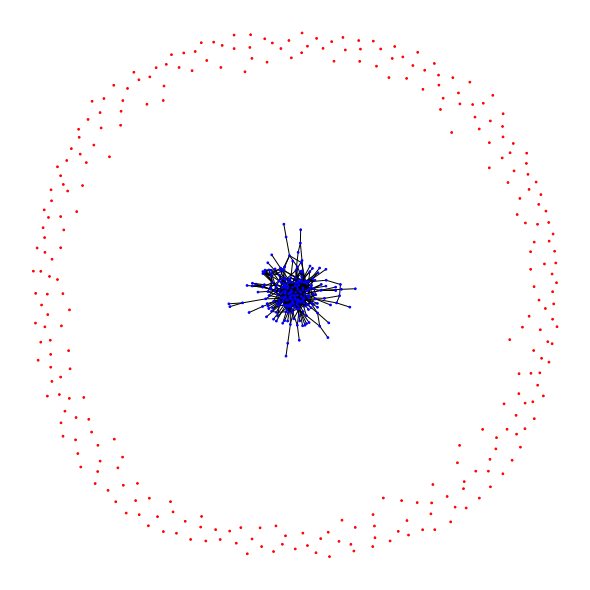

In [5]:
# LCC PLOT

DN = AF.make_disease_graph(HSN, DGA, DG_in_PPI)
AF.plot_LCC(DN, DG_in_PPI)

In [ ]:
# LOCAL MEASURES
# This cell takes a while to run...

G = LCC.copy()

nx.set_node_attributes(G, G.degree(), 'Node degree')  
nx.set_node_attributes(G, nx.betweenness_centrality(G), "Betweenness centrality")
nx.set_node_attributes(G, nx.eigenvector_centrality(G), "Eigenvector centrality")
nx.set_node_attributes(G, nx.closeness_centrality(G), "Closeness centrality")

local_measures = pd.DataFrame(index=G.nodes())
local_measures['Node degree'] = [d for n, d in G.degree()] 
local_measures['Betweenness centrality'] = pd.Series(nx.get_node_attributes(G, 'Betweenness centrality'))
local_measures['Eigenvector centrality'] = pd.Series(nx.get_node_attributes(G, 'Eigenvector centrality'))
local_measures['Closeness centrality'] = pd.Series(nx.get_node_attributes(G, 'Closeness centrality'))
local_measures['Betweenness/Degree Ratio'] = local_measures['Betweenness centrality']/local_measures['Node degree']
local_measures.index.name='Gene'

In [ ]:
# TABLE OF LOCAL MEASURES

local_measures.to_csv('local_measures.csv', index = True, header = True)

local_measures = pd.read_csv('/content/local_measures.csv', sep=',')
local_measures.head(50)

## Task 2

In [ ]:
## AUXILIARY FUNCTIONS TO PUT IN FILE

def cross_vaidation(splits,nodes,DG_in_PPI,clusters,DGA_filt,n_size=17914):#set n_size = n_nodes
    
    recall = {'std_valid':[],'ext_valid':[]}
    prec =  {'std_valid':[],'ext_valid':[]}
    f1 =  {'std_valid':[],'ext_valid':[]}
    enriched_clusters = 0
    for idx in range(0,5):
        test = set(splits[str(idx)])
        training = set(DG_in_PPI).difference(test)
        positives = set()
        for cluster in clusters:
            N = n_size
            K = len(training)
            n = len(cluster)
            k = len(set(nodes[list(cluster)]).intersection(training))+10e-10
            pval = hypergeom.sf(k=k-1, M=N, n=K, N=n)
            if pval < 0.05:
                enriched_clusters += 1
                positives = positives.union(set(nodes[list(cluster)]))
        TP = test.intersection(positives)
        FP = positives.difference(test)
        FN = test.difference(positives)
        r,p,f = metrics(TP,FP,FN)
        R,P,F = metrics(FP.intersection(DGA_filt), FP.difference(DGA_filt), DGA_filt.difference(TP.union(FN)))
        recall['std_valid'] += [r]
        prec['std_valid'] += [p]
        f1['std_valid'] += [f]
        recall['ext_valid'] += [R]
        prec['ext_valid'] += [P]
        f1['ext_valid'] += [F]
     
    print('Enriched Clusters:',enriched_clusters/5)
    return recall,prec,f1
    
def metrics(TP,FP,FN):
    recall = len(TP)/(len(TP)+len(FP)+10e-10)
    prec = len(TP)/(len(TP)+len(FN)+10e-10)
    f1 = 2*(recall/5*prec/5)/(prec/5+recall/5+10e-10)
    return recall, prec, f1


### DIAMOnD algorithm

In [ ]:
# Stores the seed genes
# For DIAMOnD we need to define two files, the PPI.txt and the seed_genes.txt:

seed_genes = DGA['geneId'].tolist()
textfile = open("seed_gene.txt", "w")
for element in seed_genes:
  if seed_genes.index(element) != len(seed_genes)-1:
    textfile.write(str(element) + "\n")
  else:
    textfile.write(str(element))
textfile.close()

In [ ]:
# gene_A = list(map(int, homo_sapiens_network['Entrez Gene Interactor A'].tolist()))
# gene_B = list(map(int, homo_sapiens_network['Entrez Gene Interactor B'].tolist()))
pairs_genes = list(LCC.edges)

In [ ]:
pairs_genes = list(LCC.edges)
# Stores the homo sapiense interactome
textfile = open("PPI_Hypertensive.txt", "w")
for gA, gB in tqdm(pairs_genes):
  textfile.write(str(gA) + ',' + str(gB) + '\n') 
textfile.close()

In [ ]:
with open(path+'Hypertensive disease_splits.json') as f:
  data = json.load(f)

In [ ]:
# Execute DIAMOND

filteredSymbolGenes_ID = DGA[DGA.geneSymbol.isin(data['4'])].geneId.tolist()
actualDt = list(set(seed_genes) - set(filteredSymbolGenes_ID))

textfile = open("seed_gene.txt", "w")
for element in actualDt:
  textfile.write(str(element) + '\n')
textfile.close()

!python3 /content/DIAMOnD/DIAMOnD.py PPI_Hypertensive.txt seed_gene.txt 200

### DiaBLE algorithm

In [ ]:
# EXECUTE DIABLE
# Change the code in the DIAMOnD script in the DiaBLE Folder (see below)

!python3 /content/DiaBLE/DIAMOnD.py PPI_Hypertensive.txt seed_gene.txt 200

AFTER LINE 317 CHANGE AS FOLLOWS: ADD THE LINES

```
  candidates = set(cluster_nodes)
  universe = set()

  for _ in range(0, 2):
    for gene in candidates.copy():
      universe |= neighbors[gene]
    candidates = universe        
  
  N = len(universe)
```


### Diffusion Based Algorithm

In [16]:
#..... ??

### Validation

In [ ]:
## AUXILIARY FUNCTIONS TO PUT IN FILE

def calculate_dcg(inters, cv, alg_name):
  # Discounted Cumulative Gain
  dcg = 0
  for dis_gene in inters:
    rank = int(cv.index(dis_gene)+1)
    dcg += np.divide(1.0, np.log2(rank+1))
  return dcg

def normalized_dcg(ndcg_scores):
  # DCG Normalized by its maximum value
  return list(np.around(np.array(ndcg_scores)/np.sum(ndcg_scores), 3)) 

### ......

#### Cross-Validation splits

In [ ]:
with open('/content/Hypertensive disease_splits.json') as f:
  dict_ = json.load(f)

with open('/content/Hypertensive disease_seed_gene.txt') as f:
  seeds = pd.read_csv(f,sep='\t',header=None)

In [ ]:
gene_dis_association = pd.read_csv('/content/curated_gene_disease_associations.tsv', sep = '\t')
gene_dis_association = gene_dis_association[gene_dis_association['diseaseName'] == 'Hypertensive disease']

In [ ]:
seeds=seeds[0].to_numpy()
seeds

In [ ]:
for k,v in dict_.items():
    print(k,v)
    ids=gene_dis_association.loc[gene_dis_association.geneSymbol.isin(v)].geneId.tolist()
    l=list(set(seeds).difference(set(ids)))
    with open('/content/drive/MyDrive/cross_{}.txt'.format(k),'w') as f:
        for item in l:
            f.write("%s\n" % item)
    

### Evaluation of performances

In [ ]:
# ....

## Optional Task 3 MCL

In [ ]:
curated_gene_desease_association_DF = pd.read_csv("/content/curated_gene_disease_associations.tsv", sep = '\t', compression = 'infer')
disease_DF = curated_gene_desease_association_DF.loc[curated_gene_desease_association_DF['diseaseId'] == 'C0020538']

In [ ]:
seed_list = list(disease_DF['geneId'])
seed_genes_symbols = list(disease_DF['geneSymbol'])

In [ ]:
result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))           
clusters = mc.get_clusters(result) 

In [ ]:
mc.draw_graph(nx.to_scipy_sparse_matrix(G), clusters, node_size=10, with_labels=False, edge_color="silver")

In [ ]:
# perform clustering using different inflation values from 1.5 and 2.5
# for each clustering run, calculate the modularity
matrix = nx.to_scipy_sparse_matrix(G)
for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

Now that we have found the clusters, we filter them in order to keep only those having at least 10 nodes and in which the seed genes are statistically overrepresented. The resulting sets are the putative desease modules.

In [ ]:
# keep clusters with at least 10 genes
big_clusters = []
for module in clusters:
    if len(module) >= 10:
        big_clusters.append(module)
print(len(clusters), len(big_clusters))

In [ ]:
# dictionary with mapping {nodeID : gene name}
val = range(G.number_of_nodes())
names = list(G.nodes())
dic = dict(zip(val, names))

In [ ]:
# run the hypergeometric test to find modules with statistically overrepresented seed genes
putative_desease_modules = []
M = G.number_of_nodes() # population size (total number of genes) 
n = len(seed_genes_symbols) # number of seed genes
p_val_list = []
for module in big_clusters:
    N = len(module) # number of draws (number of genes in the given cluster)
    x = len(set(seed_genes_symbols).intersection(set(dic[g] for g in module)))
    p_val = hypergeom.sf(x-1, M, n, N)
    if p_val < 0.05:
        putative_desease_modules.append(module)
        p_val_list.append(p_val)

In [ ]:
for i in range(len(putative_desease_modules)):
    print("Desease putative module ",i, ": ", *[dic[g] for g in putative_desease_modules[i]])

In [ ]:
header = ['ModuleID', "Number of seed genes/module", "Module size", "Seed genes", "All genes", "p-value"]
df_putative_desease_modules = pd.DataFrame(columns=header)
for i in range(len(putative_desease_modules)):
    seeds = set(seed_genes_symbols).intersection(set(dic[g] for g in putative_desease_modules[i]))
    values = [i, len(seeds), len(putative_desease_modules[i]), seeds, [dic[g] for g in putative_desease_modules[i]],p_val_list[i]]
    df = pd.DataFrame( [values], columns = header)
    df_putative_desease_modules = df_putative_desease_modules.append(df, ignore_index=True)

In [ ]:
# ???
df_putative_desease_modules